In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import humanize
import warnings

In [38]:
warnings.filterwarnings('ignore')

In [39]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80

In [40]:
apartments = pd.read_csv('../data/processed/apartments.csv')
print(apartments.shape)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]
apartments = apartments.drop(['precio_arriendo'], axis=1)
apartments.head()

(66738, 40)


,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,...,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm
1,2510-M4156145,APARTAMENTO,VENTA,4.850000e+08,84.0,3.0,3.0,680000.0,1.0,SANTA BARBARA,...,0.0,0.0,1.0,1.0,False,USAQUEN,SAN PATRICIO,Pepe Sierra,1116.77,0
3,10139-M4343016,APARTAMENTO,VENTA,4.950000e+08,77.2,3.0,2.0,367000.0,1.0,COLINA Y ALREDEDORES,...,1.0,1.0,1.0,1.0,False,SUBA,CAMPOS DE SILENCIO,Calle 161,933.85,0
4,10139-M3692828,APARTAMENTO,VENTA,1.570000e+09,213.0,3.0,4.0,994000.0,3.0,COUNTRY,...,0.0,1.0,1.0,1.0,False,USAQUEN,GINEBRA,Prado,2769.19,0
5,2456-M3860535,APARTAMENTO,VENTA,7.500000e+08,142.0,3.0,3.0,400000.0,2.0,COLINA Y ALREDEDORES,...,0.0,1.0,1.0,1.0,False,SUBA,URB. LA SIRENA,Mazurén,1704.02,0
6,3390-M4320821,APARTAMENTO,VENTA,3.670000e+09,432.0,4.0,5.0,3000000.0,4.0,CHICO,...,0.0,0.0,1.0,1.0,False,CHAPINERO,S.C. EL NOGAL,Héroes - Gel´Hada,960.91,0


In [41]:
apartments.shape

(44545, 39)

In [42]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44545 entries, 1 to 65271
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   codigo                               44545 non-null  object 
 1   tipo_propiedad                       44545 non-null  object 
 2   tipo_operacion                       44545 non-null  object 
 3   precio_venta                         44545 non-null  float64
 4   area                                 44544 non-null  float64
 5   habitaciones                         44543 non-null  float64
 6   banos                                44543 non-null  float64
 7   administracion                       40176 non-null  float64
 8   parqueaderos                         44543 non-null  float64
 9   sector                               42568 non-null  object 
 10  estrato                              44529 non-null  float64
 11  antiguedad                       

In [43]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'estado', 'longitud', 'latitud', 'descripcion',
       'datetime', 'website', 'compañia', 'last_view',
       'fecha_actualizacion_precio_venta', 'precio_venta_anterior',
       'fecha_actualizacion_precio_arriendo', 'precio_arriendo_anterior',
       'direccion', 'jacuzzi', 'piso', 'closets', 'chimenea',
       'permite_mascotas', 'gimnasio', 'ascensor', 'conjunto_cerrado',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm'],
      dtype='object')

In [44]:
apartments['datetime'] = pd.to_datetime(apartments['datetime'])

In [45]:
fotmat_tick_humanize = lambda x, pos: humanize.intword(x)

# Elimindando Outliers

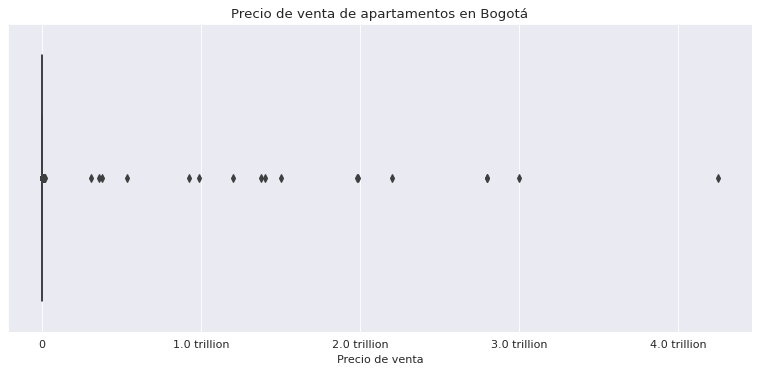

In [46]:
plt.figure(figsize=(12, 5))

sns.boxplot(x='precio_venta', data=apartments)
plt.title('Precio de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))

In [47]:
Q1 = apartments['precio_venta'].quantile(0.25)
Q3 = apartments['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.8 * IQR
upper = Q3 + 1.8 * IQR

if lower < 0:
    lower = Q1 - 0.4 * IQR

outliers = apartments.loc[(apartments['precio_venta'] < lower) | (apartments['precio_venta'] > upper)]
outliers.shape
# lower, upper

(2395, 39)

In [48]:
apartments = apartments[(apartments['precio_venta'] > lower) & (apartments['precio_venta'] < upper)]
apartments.shape

(42150, 39)

# Analisis Univariado

In [49]:
# selecionar todos los meses de datetime
apartments['month'] = apartments['datetime'].dt.month

In [50]:
# pasar el mes a string
import calendar

apartments['month'] = apartments['month'].apply(lambda x: calendar.month_abbr[x])

In [51]:
apartments['month'].value_counts()

month
Jun    18983
Aug    11121
Jul     8086
Sep     2707
Oct     1253
Name: count, dtype: int64

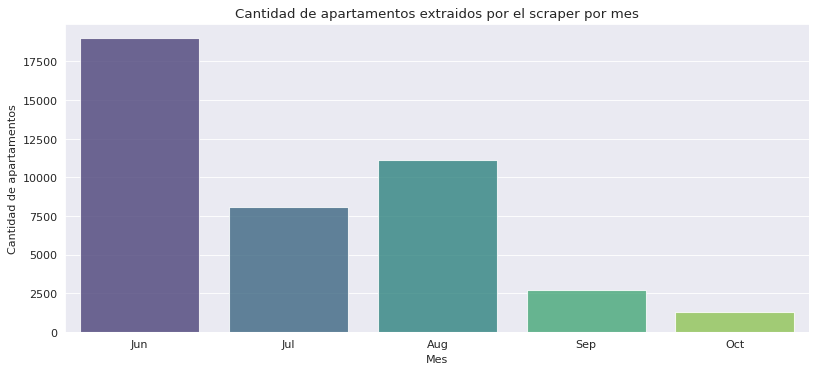

In [52]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x='month', 
    data=apartments,
    palette='viridis',
    alpha=.8
)

plt.title('Cantidad de apartamentos extraidos por el scraper por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
plt.show()

## Actualizacion de datos

In [53]:
apartments['fecha_actualizacion_precio_venta'] = pd.to_datetime(apartments['fecha_actualizacion_precio_venta'])
apartments['mes_actualizacion_precio_venta'] = apartments['fecha_actualizacion_precio_venta'].dt.month.fillna(0).astype(int)
apartments['mes_actualizacion_precio_venta'] = apartments['mes_actualizacion_precio_venta'].apply(lambda x: calendar.month_abbr[x])
apartments['mes_actualizacion_precio_venta'].value_counts()

mes_actualizacion_precio_venta
       39931
Sep      739
Aug      724
Oct      403
Jul      353
Name: count, dtype: int64

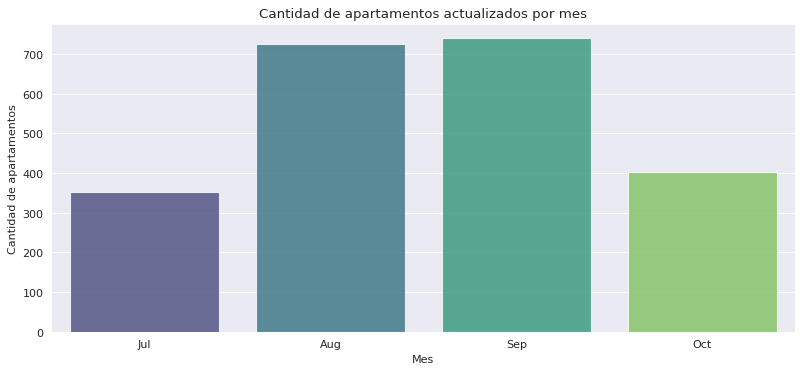

In [54]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x=apartments['mes_actualizacion_precio_venta'].loc[apartments['mes_actualizacion_precio_venta'] != ''],
    # data=apartments,
    palette='viridis',
    alpha=.8
)

plt.title('Cantidad de apartamentos actualizados por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
plt.show()

## Precio de Venta

In [56]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,"42,150.0","747,081,054.4710083","539,240,996.7706841","80,000,000.0","350,000,013.0","560,000,000.0","980,000,000.0","2,560,000,000.0"


In [57]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,42.1 thousand,747.1 million,539.2 million,80.0 million,350.0 million,560.0 million,980.0 million,2.6 billion


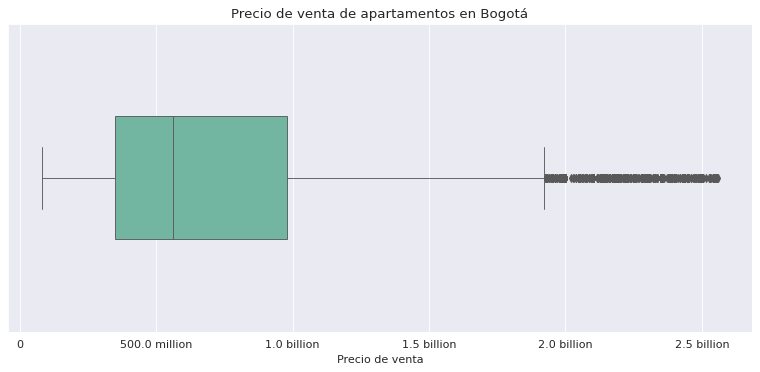

In [58]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.show()

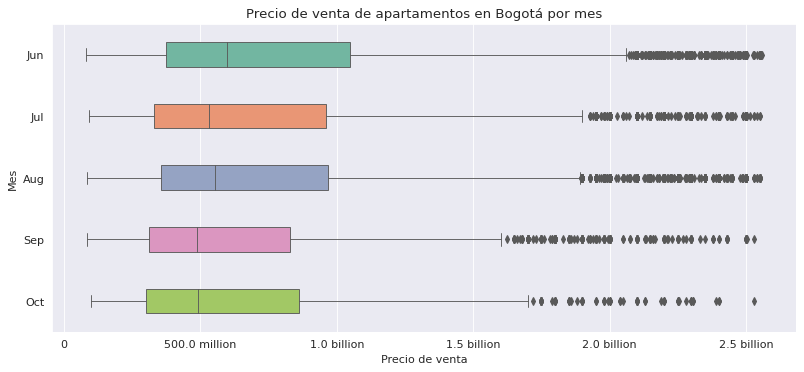

In [59]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    y='month',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá por mes')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.ylabel('Mes')
plt.show()

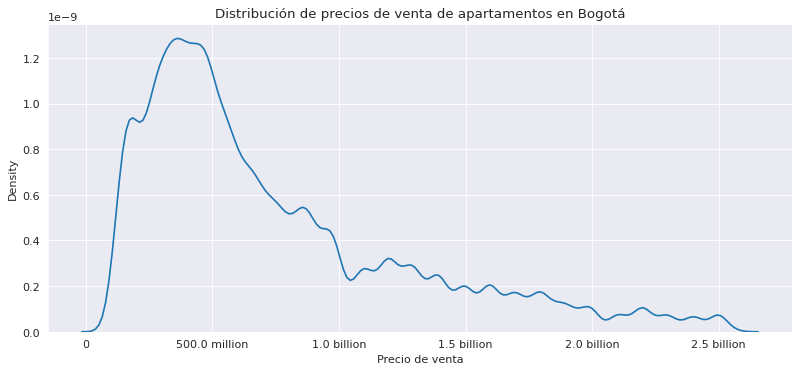

In [60]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [61]:
apartments['is_cerca_estacion_tm'].value_counts()

is_cerca_estacion_tm
0    33469
1     8681
Name: count, dtype: int64

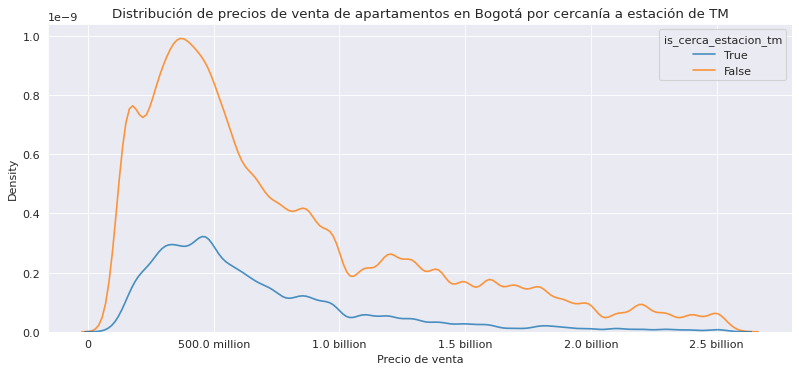

In [74]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    bw_adjust=.5,
    hue_order=[True, False],
    alpha=.8,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

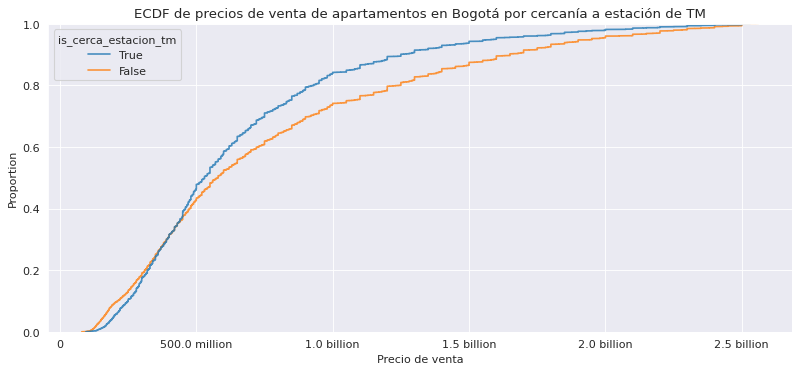

In [75]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    alpha=.8,
)

plt.title('ECDF de precios de venta de apartamentos en Bogotá por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [76]:
# stats de precio por cada mes
stats_month = apartments.groupby('month')['precio_venta'].describe()
stats_month

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
Aug,11121.0,7.439833e+08,5.409600e+08,84000000.0,355000000.0,555000000.0,9.690000e+08,2.550000e+09
Jul,8086.0,7.195818e+08,5.330273e+08,90000000.0,330000000.0,530000000.0,9.600000e+08,2.550000e+09
Jun,18983.0,7.806791e+08,5.468475e+08,80000000.0,375000000.0,599000000.0,1.050000e+09,2.560000e+09
Oct,1253.0,6.548063e+08,4.867275e+08,100000000.0,300000000.0,490000000.0,8.600000e+08,2.530000e+09
Sep,2707.0,6.490528e+08,4.966780e+08,85000000.0,310000000.0,487000000.0,8.300000e+08,2.530000e+09


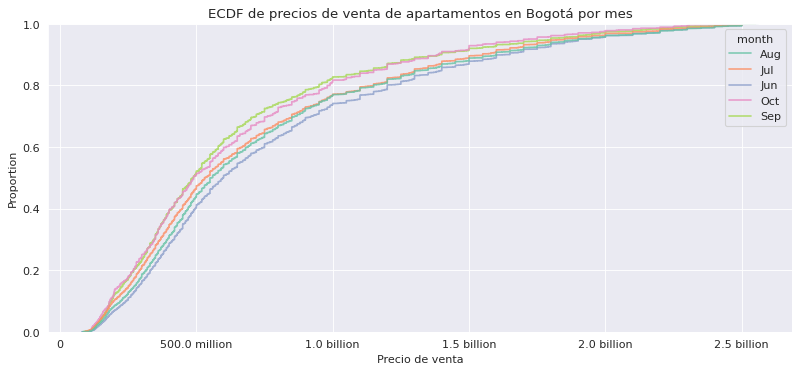

In [81]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    apartments,
    x='precio_venta',
    hue='month',
    hue_order=stats_month.index,
    palette='Set2',
    alpha=.8,
)

plt.title('ECDF de precios de venta de apartamentos en Bogotá por mes')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()


In [87]:
# stats de precio por localidad

stats_localidad = apartments.groupby('localidad')['precio_venta'].describe()
stats_localidad.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
localidad,,,,,,,,
CHAPINERO,9090.0,1.190883e+09,6.047283e+08,150000000.0,6.800000e+08,1.100000e+09,1.650000e+09,2.560000e+09
USAQUEN,16152.0,8.040544e+08,4.831288e+08,96000000.0,4.400000e+08,6.500000e+08,1.050000e+09,2.554000e+09
SUBA,8162.0,5.622656e+08,3.715803e+08,102000000.0,3.200000e+08,4.650000e+08,6.800000e+08,2.550000e+09
TEUSAQUILLO,1276.0,5.546042e+08,2.629654e+08,124000000.0,3.950000e+08,5.100000e+08,6.500000e+08,2.200000e+09
SANTA FE,598.0,4.726789e+08,2.599504e+08,100400000.0,3.200000e+08,4.275000e+08,5.567500e+08,2.400000e+09
FONTIBON,1584.0,4.705139e+08,3.390511e+08,113200000.0,2.500000e+08,3.900000e+08,5.500000e+08,2.500000e+09
BARRIOS UNIDOS,272.0,4.270493e+08,1.338755e+08,165000000.0,3.200000e+08,4.194500e+08,5.106250e+08,9.500000e+08
CANDELARIA,82.0,4.042496e+08,1.805978e+08,108000000.0,2.576307e+08,3.925000e+08,4.600000e+08,9.100000e+08
PUENTE ARANDA,222.0,3.763432e+08,2.405766e+08,103500000.0,2.300000e+08,3.250000e+08,4.380000e+08,2.328144e+09


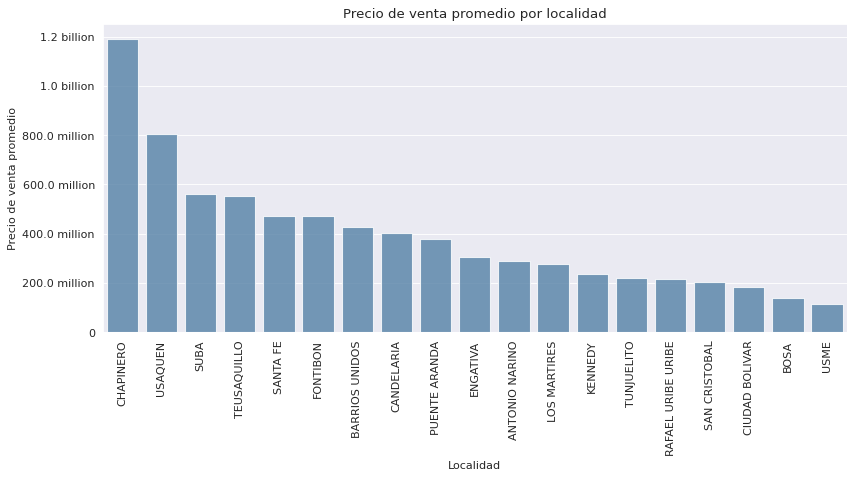

In [92]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=stats_localidad.index,
    y=stats_localidad['mean'],
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
    order=stats_localidad.sort_values(by='mean', ascending=False).index,
    color='steelblue',
)

plt.title('Precio de venta promedio por localidad')
plt.xlabel('Localidad')
plt.ylabel('Precio de venta promedio')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xticks(rotation=90)
plt.show()